# 图像解析

In [24]:
# 图像解析
from openai import OpenAI

client = OpenAI()
model = "gpt-4-turbo"
image_url = "https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1pA0iX.img?w=575&h=368&m=6"
completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role":"user",
            "content":[
                {"type":"text","text":"describe the image"},
                {
                    "type":"image_url",
                    "image_url":{
                        "url":image_url
                    }
                }
            ]
        }
    ]
)


In [6]:
print(completion.choices[0].message.content)

The image features several heads of fresh cauliflower. Each cauliflower head is surrounded by its green leaves, and some of the leaves carry small water droplets, suggesting they are fresh or have been recently washed. The cauliflowers are placed in a cardboard box, indicating they might be on display for sale, possibly at a farmer's market or a grocery store. The image is focused on the texture and fresh appearance of the cauliflowers, highlighting their whiteness and the vibrant green of the leaves.


# 多幅图片

In [7]:
# 多幅图片
image2_url = "https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1pY96P.img?w=768&h=512&m=6"
completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role":"user",
            "content":[
                {
                    "type":"text","text":"下面那副图片看上去更健康"
                },
                {
                    "type":"image_url",
                    "image_url":{
                        "url":image_url
                    }
                },
                {
                    "type":"image_url",
                    "image_url":{
                        "url":image2_url
                    }
                }
                
            ]
        }
    ]
)

In [9]:
print(completion.choices[0].message.content)

这两副图片都代表了健康的食物选项，但是花椰菜这张图可能会被视为更健康的选择。花椰菜富含纤维、维生素C和K，以及其他多种营养素，对健康有很多益处，例如助于消炎、提高免疫力和促进心血管健康。

而鸡蛋虽然蛋白质丰富、含有多种维生素和矿物质，但是对于需要限制胆固醇摄入的人来说，可能需要适量食用。因此，从蔬菜的多样性和低脂肪、低胆固醇的角度来看，花椰菜显得更加健康。


# 本地图片转换base64格式进行上传

In [ ]:
# 本地图片转换base64格式进行上传
import base64

def encode_image(image_path):
    with open(image_path,"rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
        
local_image = "../../data/image/demo.png"
base64_image = encode_image(local_image)

completion = client.chat.completions.create(
    model=model,
    max_tokens=300,
    messages=[
        {
            "role":"user",
            "content":[
                {"type":"text","text":"描述图片内容"},
                {
                    "type":"image_url",
                     "image_url":{
                         "url": f"data:image/jpeg;base64,{base64_image}"
                     }
                 }
            ]
        }
    ]
)


In [23]:
print(completion.choices[0].message.content)

这张图片描绘了一位年轻的女性动漫人物，她穿着冬季衣物，包括一件深紫色的羽绒外套和一个蓝色的围巾。她的头戴着一顶带有球形装饰的浅灰色毛线帽，蓝色的眼睛看起来非常生动。这个角色看上去非常友好和开心，微笑着。整体色调和服装细节传达出温暖和冬季的氛围。


# 注意
## 1.注意图像的质量可以选择low/high/auto,默认auto,上传图片会计算token
## 2.长时间会话，建议使用url非base64,而且最好进行大小处理

In [ ]:
# 注意
# 
 messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
            "detail": "high" # high/low/auto
          },
        },
      ],
    }
  ]

# 结合tts生成解说
## 需要做的有三点：
  ### 1.捕获界面图像
  ### 2.图像生成介绍
  ### 3.介绍生成语音

In [4]:

import cv2
from openai import OpenAI
import base64
from IPython.display import Image, Audio,display
import time 

In [10]:
# 1.捕获界面图像

import cv2
from openai import OpenAI
import base64
from IPython.display import Image, Audio

file_path = '../../data/video/国风大典.mp4'
video = cv2.VideoCapture(file_path)
base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break

    _, buffer = cv2.imencode(".png", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print("frames read：",len(base64Frames))

frames read： 405


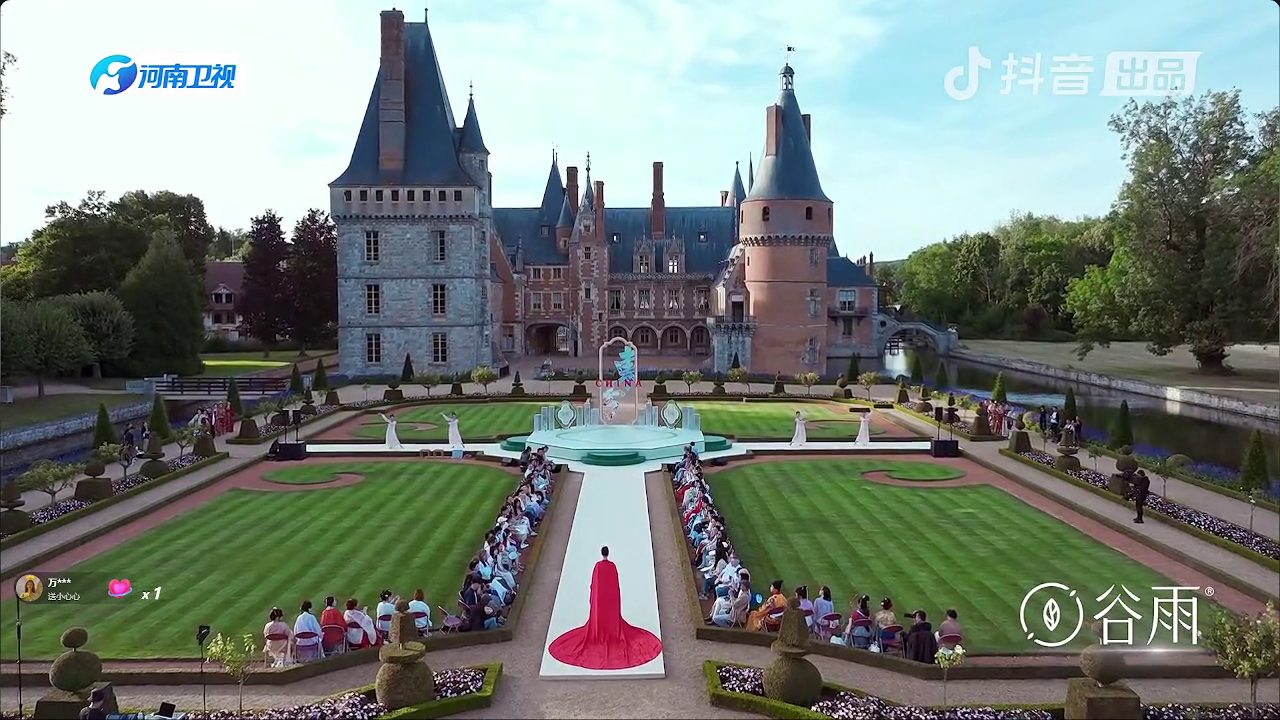

In [11]:
# 确定图片正常
display_handler = display(None, display_id=True)
base64Frames
for img in base64Frames:
    display_handler.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.02)

In [7]:
data = base64Frames[0]

In [17]:
# 生成文字
client = OpenAI()

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "这是我想上传的一段视频的画面。生成一个引人注目的描述，我可以与视频一起上传",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

'''
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

'''

“欢迎来到本次令人期待已久的盛会，现在我们要开启一扇东方美学之窗！ 📺✨ 视频中展示了华丽的场景和一位充满热情的主持人，为我们揭开了这场视觉盛宴的序幕。不要错过这次了解与探索中华文化与艺术的难得机会！🌸🏯 #传统文化 #东方美学 #视觉盛宴”


In [18]:
model ="tts-1"
voice = "onyx"
save_path = "../../data/audio/国风大典.mp3"
with  client.audio.speech.with_streaming_response.create(
    
    model=model,
    voice= voice,
    input=result.choices[0].message.content
) as response:
    
    response.stream_to_file(save_path)
    